In [1]:
import torch
import random
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')

def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)

enforce_reproducibility()

train_data  = pd.read_parquet("/content/train.parquet")
test_data   = pd.read_parquet("/content/train.parquet")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
questions_fi = test_data.loc[(test_data["lang"] == "fi")]
questions_fi

,question,context,lang,answerable,answer_start,answer,answer_inlang
9137,Mitkä olivat Rooman alkuvaiheet?,"In historiography, ancient Rome is Roman civil...",fi,True,0,"In historiography, ancient Rome is Roman civil...",None
9138,Kuka oli toisen maailmansodan jälkeisen sosial...,Rákosi had difficulty managing the economy and...,fi,True,187,Mátyás Rákosi,None
9139,Mikä oli roomalaisten antama nimi nykyisen Unk...,Hungary in its modern (post-1946) borders roug...,fi,True,286,Pannonia,None
9140,Kuinka monta ihmistä menehtyi Suezin kriisin a...,"On 25 January 1952, British forces attempted t...",fi,True,131,deaths of 41 Egyptians,None
9141,Millä vuosikymmenellä Yhdysvaltojen varhaishis...,The history of the United States began with th...,fi,True,87,"15,000 BC",None
...,...,...,...,...,...,...,...
15171,Minä vuonna Italia haki paikkaansa Euroopan va...,di Diano National Park in Campania. In ancient...,fi,False,-1,1870,1870
15172,Minä vuonna Kellopeliappelsiini julkaistiin?,"Thiamylal or ""thioseconal"" (brand name ""Surita...",fi,False,-1,1971,1971
15173,Minä vuonna Tom Fletcher on syntynyt?,Thomas Michael Fletcher (born 17 July 1985) is...,fi,True,-1,"July 17, 1985",17. heinäkuuta 1985
15174,Minä vuonna William R. Catton Jr. kuoli?,"William Robert Catton Jr. (January 15, 1926 – ...",fi,True,57,2015,2015


In [3]:
train_data.loc[(train_data["lang"] == "fi")][["question","context","answerable"]]

,question,context,answerable
9137,Mitkä olivat Rooman alkuvaiheet?,"In historiography, ancient Rome is Roman civil...",True
9138,Kuka oli toisen maailmansodan jälkeisen sosial...,Rákosi had difficulty managing the economy and...,True
9139,Mikä oli roomalaisten antama nimi nykyisen Unk...,Hungary in its modern (post-1946) borders roug...,True
9140,Kuinka monta ihmistä menehtyi Suezin kriisin a...,"On 25 January 1952, British forces attempted t...",True
9141,Millä vuosikymmenellä Yhdysvaltojen varhaishis...,The history of the United States began with th...,True
...,...,...,...
15171,Minä vuonna Italia haki paikkaansa Euroopan va...,di Diano National Park in Campania. In ancient...,False
15172,Minä vuonna Kellopeliappelsiini julkaistiin?,"Thiamylal or ""thioseconal"" (brand name ""Surita...",False
15173,Minä vuonna Tom Fletcher on syntynyt?,Thomas Michael Fletcher (born 17 July 1985) is...,True
15174,Minä vuonna William R. Catton Jr. kuoli?,"William Robert Catton Jr. (January 15, 1926 – ...",True


## 1-. [Naive Bayes Classifier] - [Add 1 smoothing] - Finnish

In [45]:
#Input: training data
def train_naive_bayes_fi(train_data, lang:str = "ru", language:str = "russian"):
    log_p_c = 0
    log_p_w_c = 0

    num_answerable_questions    = train_data.loc[(train_data["answerable"])]["answerable"].count()
    num_unanswerable_questions  = train_data.loc[(train_data["answerable"]) == False]["answerable"].count()
    num_questions               = len(train_data)

    #Tokenize and use bag of words method. One count for answerable, another for unanswerable

    #Answerable
    tokens_ans = train_data.loc[(train_data["lang"] == lang) & (train_data["answerable"])]["question"].apply(lambda row: nltk.word_tokenize(row, language=language)).to_list()
    tokens_ans = [item for sublist in tokens_ans for item in sublist]


    counts_answerable = {}
    for token in tokens_ans:
        if token in counts_answerable:
            counts_answerable[token] += 1
        else:
            counts_answerable[token] = 1
    V_ans = list(counts_answerable.keys())

    #Unanswerable
    tokens_unans = train_data.loc[(train_data["lang"] == lang) & (train_data["answerable"])== False]["question"].apply(lambda row: nltk.word_tokenize(row, language=language)).to_list()
    tokens_unans = [item for sublist in tokens_unans for item in sublist]


    counts_unanswerable = {}
    for token in tokens_ans:
        if token in counts_unanswerable:
            counts_unanswerable[token] += 1
        else:
            counts_unanswerable[token] = 1
    V_unans = list(counts_unanswerable.keys())

    V = V_ans + [item for item in V_unans if item not in V_ans]

    #Calculate log probabilities
    log_p_c = {"answerable":np.log(num_answerable_questions/num_questions),"unanswerable":np.log(num_unanswerable_questions/num_questions)}


    #Calculating the sum of the denominator for the calculation of log odds
    general_counts_ans = {}
    for w in V:
        if w in counts_answerable:
            general_counts_ans[w] = counts_answerable[w]
        else:
            general_counts_ans[w] = 1
    log_sum_ans = sum(general_counts_ans.values())

    general_counts_unans = {}
    for w in V:
        if w in counts_unanswerable:
            general_counts_unans[w] = counts_unanswerable[w] + 1
        else:
            general_counts_unans[w] = 1
    log_sum_unans = sum(general_counts_unans.values())

    #Calculation of P(w|answerable)
    log_p_w_c_ans = {}
    for w in V:
        log_p_w_c_ans[w] = np.log(counts_answerable[w] + 1) - log_sum_ans

    #Calculation of P(w|unanswerable)
    log_p_w_c_unans = {}
    for w in V:
        log_p_w_c_unans[w] = np.log(counts_unanswerable[w] + 1) - log_sum_unans

    log_p_w_c = {"answerable":log_p_w_c_ans,"unanswerable":log_p_w_c_unans}

    model = [V,log_p_c,log_p_w_c]

    return model


In [46]:
def naive_bayes_fi(model,text, language:str = "russian"):
    text_tokens = nltk.word_tokenize(text, language=language)
    V           =  model[0]
    log_p_c     =  model[1]
    log_p_w_c   =  model[2]

    sum_ans = log_p_c["answerable"]
    for word in text_tokens:
        if word in V:
            sum_ans += log_p_w_c["answerable"][word]

    sum_unans = log_p_c["unanswerable"]
    for word in text_tokens:
        if word in V:
            sum_unans += log_p_w_c["unanswerable"][word]

    return (sum_ans >= sum_unans)

In [52]:
model = train_naive_bayes_fi(train_data, "ja", "finnish")

def evaluate(test_data,model, lang:str = "ru"):
    test = test_data.loc[(test_data["lang"] == lang)][["question","answerable"]]
    test['eval'] = test['question'].apply(lambda x: naive_bayes_fi(model, x))
    test['is_correct'] = test['answerable'] == test['eval']

    num_quest = len(test)
    num_correct = test["is_correct"].sum()

    return num_correct/num_quest

evaluate(test_data,model, "ja")

0.8383311603650587

Accuracy: 0.8855269793242562
Precision: 0.8855269793242562
Recall: 1.0
F1 Score: 0.9392885798341802


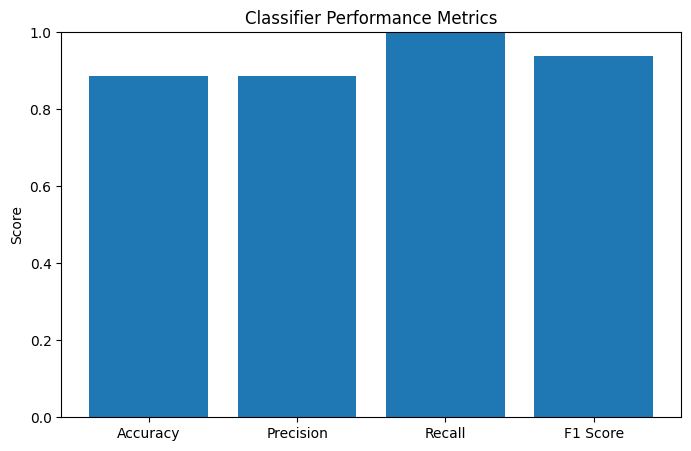

In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def evaluate_with_metrics(test_data, model, language:str = "ru"):
    # Filter and make predictions
    test = test_data.loc[(test_data["lang"] == language)][["question", "answerable"]]
    test['predicted'] = test['question'].apply(lambda x: naive_bayes_fi(model, x))

    # Calculate metrics
    accuracy = (test['answerable'] == test['predicted']).mean()
    precision = precision_score(test['answerable'], test['predicted'], zero_division=0)
    recall = recall_score(test['answerable'], test['predicted'], zero_division=0)
    f1 = f1_score(test['answerable'], test['predicted'], zero_division=0)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    # Visualization
    metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
    plt.figure(figsize=(8, 5))
    plt.bar(metrics.keys(), metrics.values())
    plt.title("Classifier Performance Metrics")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.show()

evaluate_with_metrics(test_data, model)


Accuracy: 0.8805268109125117
Precision: 0.8805268109125117
Recall: 1.0
F1 Score: 0.9364682341170585


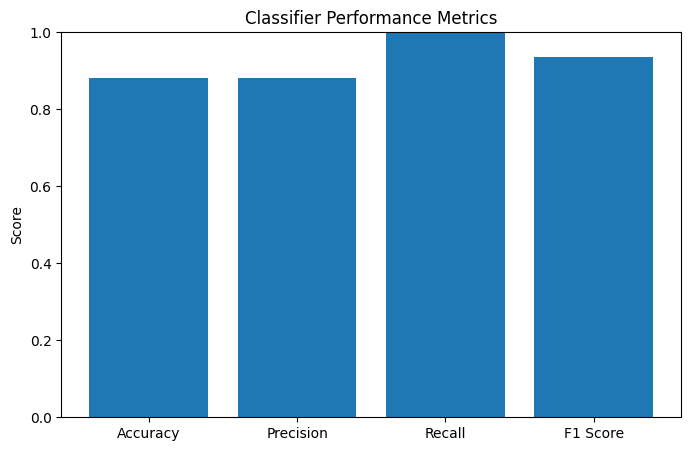

In [54]:
evaluate_with_metrics(test_data, model, "fi")

Accuracy: 0.8383311603650587
Precision: 0.8383311603650587
Recall: 1.0
F1 Score: 0.9120567375886525


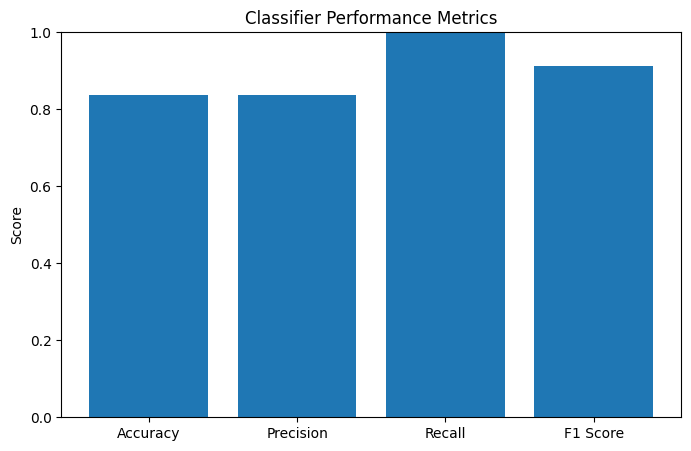

In [53]:
evaluate_with_metrics(test_data, model, "ja")

## 2.- [BiLSTM] - [BPEmb] - Finnish

In [4]:
!pip install bpemb

In [5]:
!pip install tensorflow

In [10]:
from bpemb import BPEmb
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences


bpemb_fi = BPEmb(lang="ja", vs=100000, dim=300)
train_fi = train_data.loc[(train_data["lang"] == "ja")]

# Sample question and context
question_fi = train_fi["question"].to_list()
context_fi  = train_fi["context"].to_list()
labels_fi   = np.array(train_fi["answerable"].to_list()).astype('int')

print(len(question_fi))

# Encode questions and contexts
question_ids = [bpemb_fi.encode_ids(text) for text in question_fi]
context_ids = [bpemb_fi.encode_ids(text) for text in context_fi]

print("Length of question_ids:", len(question_ids))
print("Length of context_ids:", len(context_ids))
print("Length of labels_fi:", len(labels_fi))


# Determine maximum sequence lengths
max_len_question = max(len(seq) for seq in question_ids)
max_len_context = max(len(seq) for seq in context_ids)

# Pad sequences
question_padded = pad_sequences(question_ids, maxlen=max_len_question, padding='post')
context_padded = pad_sequences(context_ids, maxlen=max_len_context, padding='post')

# Split data
from sklearn.model_selection import train_test_split

print(len(question_padded),len(context_padded),len(labels_fi))

X_question_train, X_question_val, X_context_train, X_context_val, y_train, y_val = train_test_split(
    question_padded, context_padded, labels_fi, test_size=0.1, random_state=42
)

#Build the model
vocab_size = bpemb_fi.vocab_size
embedding_dim = bpemb_fi.dim
embedding_matrix = bpemb_fi.vectors

# Question Input
question_input = Input(shape=(max_len_question,), name='question_input')
question_embedding = Embedding(input_dim=vocab_size,
                               output_dim=embedding_dim,
                               weights=[embedding_matrix],
                               input_length=max_len_question,
                               trainable=False)(question_input)
question_lstm = Bidirectional(LSTM(128))(question_embedding)

# Context Input
context_input = Input(shape=(max_len_context,), name='context_input')
context_embedding = Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              weights=[embedding_matrix],
                              input_length=max_len_context,
                              trainable=False)(context_input)
context_lstm = Bidirectional(LSTM(128))(context_embedding)
combined = Concatenate()([question_lstm, context_lstm])

# Dense Layers
dense = Dense(64, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(dense)

model_fi = Model(inputs=[question_input, context_input], outputs=output)

# Compile Model
model_fi.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model_fi.fit(
    {'question_input': X_question_train, 'context_input': X_context_train},
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(
        {'question_input': X_question_val, 'context_input': X_context_val},
        y_val
    )
)




downloading https://nlp.h-its.org/bpemb/ja/ja.wiki.bpe.vs100000.model


100%|██████████| 2105911/2105911 [00:00<00:00, 3097156.76B/s]


downloading https://nlp.h-its.org/bpemb/ja/ja.wiki.bpe.vs100000.d300.w2v.bin.tar.gz


100%|██████████| 112207603/112207603 [00:05<00:00, 21328944.36B/s]


2301
Length of question_ids: 2301
Length of context_ids: 2301
Length of labels_fi: 2301
2301 2301 2301


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.8038 - loss: 0.4709 - val_accuracy: 0.8571 - val_loss: 0.3413
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.8692 - loss: 0.3034 - val_accuracy: 0.8831 - val_loss: 0.2492
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9207 - loss: 0.1984 - val_accuracy: 0.8874 - val_loss: 0.2501
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9358 - loss: 0.1730 - val_accuracy: 0.9048 - val_loss: 0.2383
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9585 - loss: 0.1111 - val_accuracy: 0.8961 - val_loss: 0.2494
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9829 - loss: 0.0524 - val_accuracy: 0.8874 - val_loss: 0.3294
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9943 - loss: 0.0216 - val_accuracy: 0.9004 - val_loss: 0.4108
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9970 - loss: 0.0117 - val_accuracy: 0.8918 - v

##

In [11]:
from sklearn.metrics import classification_report

test_fi = test_data.loc[(test_data["lang"] == "fi")]

question_fi = test_fi["question"].to_list()
context_fi  = test_fi["context"].to_list()
labels_fi   = np.array(test_fi["answerable"].to_list()).astype('int')


# Encode questions and contexts
question_ids = [bpemb_fi.encode_ids(text) for text in question_fi]
context_ids = [bpemb_fi.encode_ids(text) for text in context_fi]


# Determine maximum sequence lengths
max_len_question = max(len(seq) for seq in question_ids)
max_len_context = max(len(seq) for seq in context_ids)

# Pad sequences
question_padded = pad_sequences(question_ids, maxlen=max_len_question, padding='post')
context_padded = pad_sequences(context_ids, maxlen=max_len_context, padding='post')


# Predict on validation data
predictions = model_fi.predict({'question_input': question_padded, 'context_input': context_padded})
predicted_labels = (predictions > 0.5).astype('int').flatten()



67/67 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step


In [12]:
test_labels  = np.array(test_fi["answerable"].to_list()).astype('int')
predicted_labels = np.array(predicted_labels).astype('int')

same_positions = sum([1 for a, b in zip(test_labels, predicted_labels) if a == b])
percentage = (same_positions / len(predicted_labels)) * 100

print(f"Success percentage of this model is {percentage}")

Success percentage of this model is 99.38852304797742


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
Accuracy: 0.9878313776618861
Precision: 0.9937662337662337
Recall: 0.9917055469155003
F1 Score: 0.9927348209652309


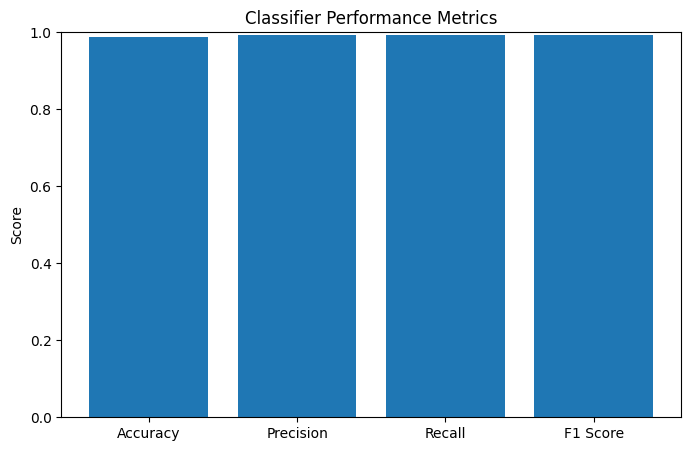

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def evaluate_with_metrics(test_data, model, bpemb, language="fi"):
    # Filter data for the specified language
    test = test_data.loc[(test_data["lang"] == language)]

    # Encode and pad test questions and contexts
    question_fi = test["question"].to_list()
    context_fi = test["context"].to_list()
    labels_fi = np.array(test["answerable"].to_list()).astype('int')

    question_ids = [bpemb.encode_ids(text) for text in question_fi]
    context_ids = [bpemb.encode_ids(text) for text in context_fi]

    max_len_question = max(len(seq) for seq in question_ids)
    max_len_context = max(len(seq) for seq in context_ids)

    question_padded = pad_sequences(question_ids, maxlen=max_len_question, padding='post')
    context_padded = pad_sequences(context_ids, maxlen=max_len_context, padding='post')

    # Predict with the model
    predictions = model.predict({'question_input': question_padded, 'context_input': context_padded})
    predicted_labels = (predictions > 0.5).astype('int').flatten()

    # Calculate metrics
    accuracy = accuracy_score(labels_fi, predicted_labels)
    precision = precision_score(labels_fi, predicted_labels, zero_division=0)
    recall = recall_score(labels_fi, predicted_labels, zero_division=0)
    f1 = f1_score(labels_fi, predicted_labels, zero_division=0)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    # Visualization
    metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
    plt.figure(figsize=(8, 5))
    plt.bar(metrics.keys(), metrics.values())
    plt.title("Classifier Performance Metrics")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.show()

# Run the function with test data and model
evaluate_with_metrics(test_data, model_fi, bpemb_fi, "ja")
